In [187]:
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import itertools as it
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
from skimage import data, io
from skimage.feature import match_template
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
from skimage import util
from skimage.draw import circle
import skimage
from skimage.morphology import binary_dilation, erosion, dilation, opening, binary_closing, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import trackpy as tp
import pylab
import math
from skimage.measure import label, regionprops

from joblib import Parallel, delayed
import multiprocessing
import math

# Optionally, tweak styles. 
# mpl.rc('figure',  figsize=(10, 6))
#mpl.rc('image', cmap='gray')

dataDir = '/media/felix/FeDa01/MosquitoData_FeDa/biteData_FeDa/181212_01/02/'
# saveDir = '/home/felix/MosquitoData/wellPlateBites/180815_wellGel/processed'

frames = pims.ImageSequence(dataDir+'/*.png', as_grey=True)

In [ ]:
ROI = [165, 87, 1536, 1832] ###coordinates per ImageJ convention

In [ ]:
f = frames[0]
f = f[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
plt.imshow(f)

In [158]:
start = 10
stop = len(frames) - 100
step = math.floor(len(frames)/13)

numBGframes = int(np.ceil((stop - start) /step) + 1)
frameSize = frames[1].shape
BG = np.zeros([frameSize[0], frameSize[1], numBGframes])

# for i in it.chain(range( ), range(738,1007, 10)):
#     j += 1
#     BG = BG + np.invert(frames[i])

j = 1
for i in range(start, stop, step):
    j += 1
    BG[:, :, j - 1] = np.invert(frames[i])    

BG = np.median(BG, axis=2)

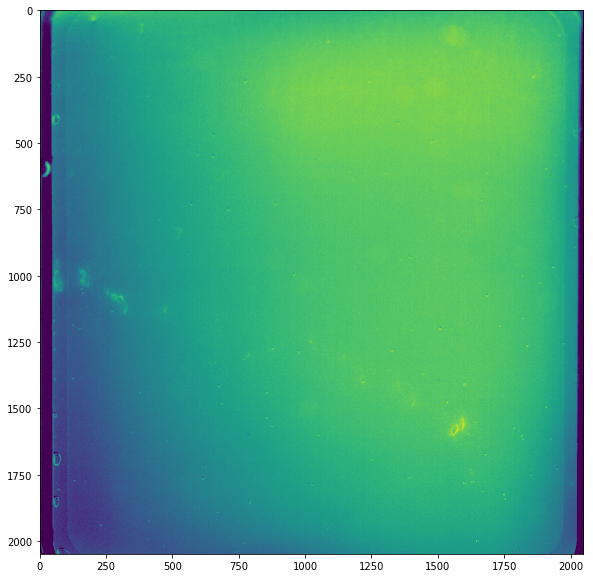

In [159]:
plt.figure(figsize=(25,10))
plt.imshow(BGn)

In [364]:
# selem1 = disk(8)
# selem2 = disk(1)

# coordinatesAll = np.zeros((1,3))
# centroidsAll = np.zeros((1,3))
# frameSize = frames[1].shape
# BGbefore = 20
# BGafter = 11
# BGstep = 4


##whole set from 1 - 3815

def trackMosq(i):
    selem1 = disk(8)
    selem2 = disk(1)
#     BG = np.zeros(frameSize)
#     j = 0
#     for k in it.chain(range(i-BGbefore, i+BGafter, BGstep), range(i+300, i+500, 20) ):
#         j += 1
#         BG = BG + np.invert(frames[k])
#     BG = BG / j
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
#     A = frames[i]
#     A = A[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
    B = A - BG
#     Bm = B - B.min()
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 50
    Bts = remove_small_objects(Bt, min_size=500)
    Be = erosion(Bts, selem2)
    Bf = remove_small_objects(Be, min_size=500)
    Bc = binary_closing(Bf, selem1)
    #Be = erosion(Bf, selem2)
    C = B * Bc
    eroded = erosion(C, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    erL = label(eroded>0)
    erR = regionprops(erL, C)
    l = 1
    for props in erR:
        if props.area > 30000:
            erL[erL==l] = 0
        if props.major_axis_length > 400:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf, C)
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
#         print(props.max_intensity)
        numCent += 1
#         [y0, x0] = props.centroid
#         centroids = np.vstack((centroids, props.centroid))
#     eroded = erosion(eroded, selem2)
    coordinates = peak_local_max(erodedF, min_distance=100, exclude_border=1)
    cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
    frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
    frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
    coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
    return centroidsF, coordinatesF
#     coordinatesAll = np.vstack((coordinatesAll,coordinatesF)) 
#     centroidsAll = np.vstack((centroidsAll,centroidsF)) 
#     os.chdir(saveDir)
#     plt.imshow(frames[i], cmap=plt.cm.gray)
#     plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
#     plt.xlim([0,2592])
#     plt.ylim([0,1944])
#     plt.savefig("coorIm" + str(i).zfill(6) + ".png",dpi=200)
#     plt.figure(1)
#     plt.imshow(np.flipud(frames[i]), cmap=plt.cm.gray)
#     plt.autoscale(False)
#     plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
#     plt.show()
    
# df = pd.DataFrame(coordinatesAll)
# df_centroids = pd.DataFrame(centroidsAll)



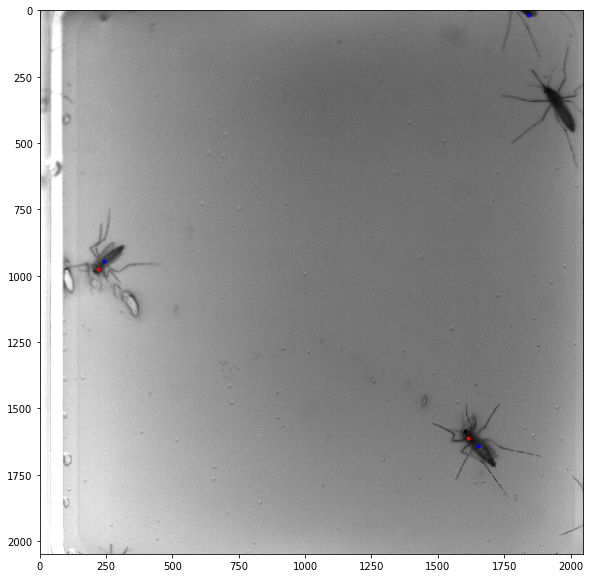

In [359]:
i = 1840
cens, coors = trackMosq(i)
plt.figure(figsize=(25,10))
plt.imshow(frames[i], cmap = 'gray')
plt.plot(cens[:,1],cens[:,0],'b.')
plt.plot(coors[:,1],coors[:,0],'r.')

In [369]:
inputs = range(1, 1850)
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(trackMosq)(i) for i in inputs)

In [370]:
centroidsAllT = np.zeros((1,3))
coordinatesAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))
    coordinatesAllT = np.vstack((coordinatesAllT,results[i][1]))

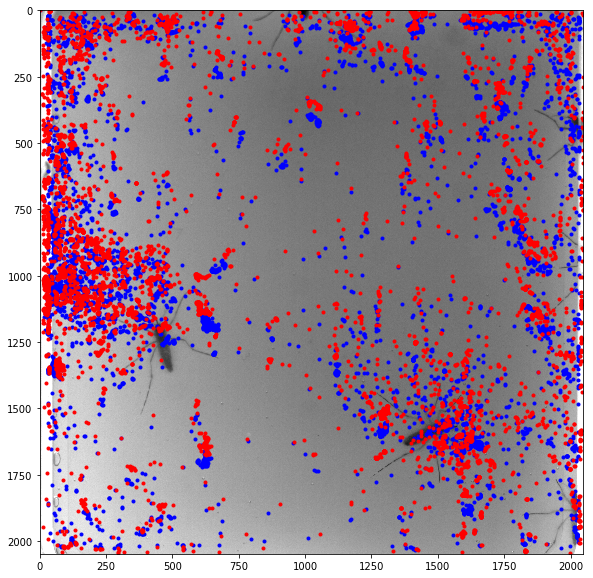

In [371]:
plt.figure(figsize=(25,10))
plt.imshow(frames[10], cmap = 'gray')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'b.')
plt.plot(coordinatesAllT[:,1],coordinatesAllT[:,0],'r.')

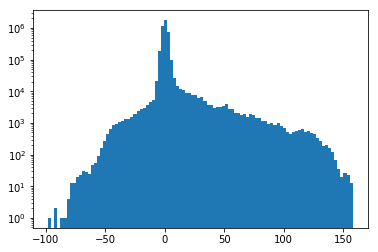

In [227]:
_=plt.hist(Bm.flatten(), bins=100, log=True)

In [355]:
selem1 = disk(8)
selem2 = disk(1)

coordinatesAll = np.zeros((1,3))
centroidsAll = np.zeros((1,3))
frameSize = frames[1].shape
BGbefore = 20
BGafter = 11
BGstep = 4


##whole set from 1 - 3815

for i in range(1440,1441):
#     BG = np.zeros(frameSize)
#     j = 0
#     for k in it.chain(range(i-BGbefore, i+BGafter, BGstep), range(i+300, i+500, 20) ):
#         j += 1
#         BG = BG + np.invert(frames[k])
#     BG = BG / j
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
#     A = frames[i]
#     A = A[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
    B = A - BG
#     Bm = B - B.min()
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 50
    Bts = remove_small_objects(Bt, min_size=500)
    Be = erosion(Bts, selem2)
    Bf = remove_small_objects(Be, min_size=500)
    Bc = binary_closing(Bf, selem1)
    #Be = erosion(Bf, selem2)
    C = B * Bc
    eroded = erosion(C, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    erL = label(eroded>0)
    erR = regionprops(erL, C)
    l = 1
    for props in erR:
        if props.area > 30000:
            erL[erL==l] = 0
        if props.major_axis_length > 400:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf, C)
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
#         print(props.max_intensity)
        numCent += 1
#         [y0, x0] = props.centroid
#         centroids = np.vstack((centroids, props.centroid))
#     eroded = erosion(eroded, selem2)
    coordinates = peak_local_max(erodedF, min_distance=100, exclude_border=1)
    cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
    frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
    frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
    coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
    coordinatesAll = np.vstack((coordinatesAll,coordinatesF)) 
    centroidsAll = np.vstack((centroidsAll,centroidsF)) 
#     os.chdir(saveDir)
#     plt.imshow(frames[i], cmap=plt.cm.gray)
#     plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
#     plt.xlim([0,2592])
#     plt.ylim([0,1944])
#     plt.savefig("coorIm" + str(i).zfill(6) + ".png",dpi=200)
#     plt.figure(1)
#     plt.imshow(np.flipud(frames[i]), cmap=plt.cm.gray)
#     plt.autoscale(False)
#     plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
#     plt.show()
    
# df = pd.DataFrame(coordinatesAll)
df_centroids = pd.DataFrame(centroidsAll)



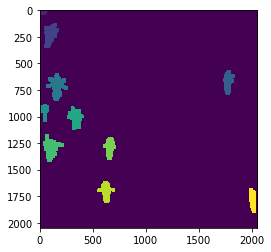

In [356]:
plt.imshow(erLf)

In [349]:
erR[4].major_axis_length

222.66583593354503

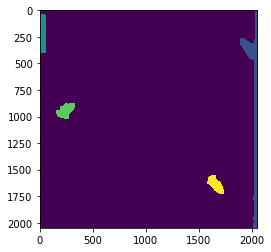

In [324]:
plt.imshow(erLf)

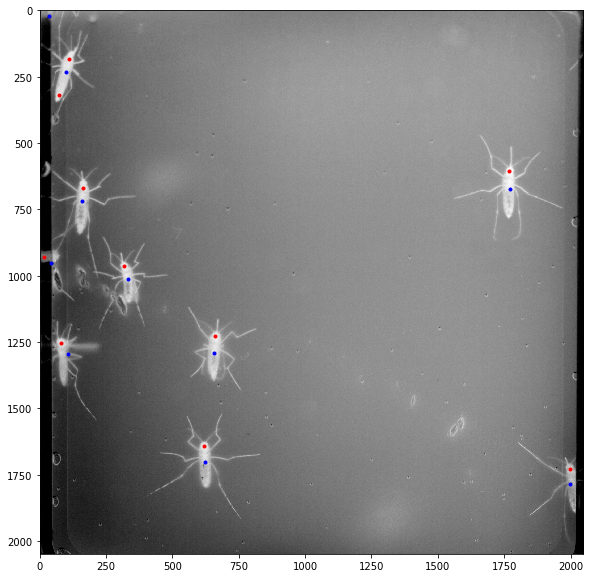

In [357]:
plt.figure(figsize=(25,10))
plt.imshow(A, cmap = 'gray')
plt.plot(centroidsF[:,1],centroidsF[:,0],'b.')
plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')

In [271]:
coordinates

array([[2046, 1896],
       [2046, 1895],
       [2046, 1894],
       ...,
       [   1,  156],
       [   1,  155],
       [   1,  154]])

In [97]:
#from tempfile import TemporaryFile
os.chdir(saveDir)
#outfile = TemporaryFile()
# np.save('coordinatesAll180627_01.npy', coordinatesAllT)

NameError: name 'saveDir' is not defined

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
from timeit import default_timer as timer


##whole set from 1 - 3965

inputs = range(5,1500)

def mosCoordinate(i):
    selem1 = disk(8)
    selem2 = disk(1)
    frameSize = frames[1].shape
#     BGbefore = 20
#     BGafter = 11
#     BGstep = 4
#     BG = np.zeros(frameSize)
#     j = 0
#     for k in it.chain(range(i-BGbefore, i+BGafter, BGstep), range(i+300, i+500, 20) ):
#         j += 1
#         BG = BG + np.invert(frames[k])
#     BG = BG / j
    A = frames[i]
    A = A[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
    B = A #- BG
    Bm = B - B.min()
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 100
    Be = erosion(Bt, selem2)
    Bf = remove_small_objects(Be, min_size=100)
    #Be = erosion(Bf, selem2)
    C = B * Bf
    eroded = erosion(C, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    erL = label(eroded>0)
    erR = regionprops(erL)
    centroids = np.zeros([len(erR), 2])
    numCent = 0
    for props in erR:
        centroids[numCent] = props.centroid
        numCent += 1
#         [y0, x0] = props.centroid
#         centroids = np.vstack((centroids, props.centroid))
#     eroded = erosion(eroded, selem2)
#     coordinates = peak_local_max(eroded, min_distance=100, exclude_border=1)
#     cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
#     frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
#     frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
#     coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
    return centroidsF

num_cores = multiprocessing.cpu_count()
    
results = Parallel(n_jobs=num_cores)(delayed(mosCoordinate)(i) for i in inputs)

centroidsAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i]))


In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(A, cmap = 'gray')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'r.', alpha = 0.5)
# print(coordinatesF)
# print(Bm.max())

In [373]:
df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_cenAllT.head()

,y,x,frame
0,0.000000,0.000000,0.0
1,110.130546,2004.435868,1.0
2,210.228719,1257.575367,1.0
3,470.594869,61.600290,1.0
4,932.991606,144.551959,1.0


In [374]:
df_coorAllT = pd.DataFrame(coordinatesAllT)
df_coorAllT = df_coorAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_coorAllT.head()

,y,x,frame
0,0.0,0.0,0.0
1,1514.0,1305.0,1.0
2,1379.0,1363.0,1.0
3,889.0,131.0,1.0
4,445.0,59.0,1.0


In [375]:
t = tp.link_df(df_cenAllT, 400, memory=5)

Frame 1500: 4 trajectories present.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



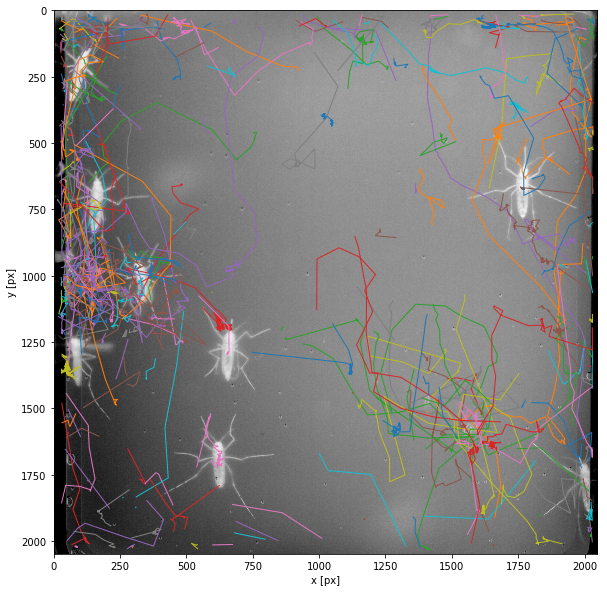

In [376]:
# os.chdir(saveDir)
fig1 = plt.figure(figsize=(25,10))
plt.imshow(A, cmap='gray')
# plt.plot(coordinatesAllT[:,1],coordinatesAllT[:,0],'r.',alpha=0.5, markersize=10)
tp.plot_traj(t, plot_style={'linewidth':'1.0'})
# fig1.savefig("180221_coorIm01.pdf", bbox_inches='tight')

In [378]:
# os.chdir('/media/felix/FeDa01/MosquitoData_FeDa/biteData_FeDa/181212_01/181212_processed/')
df_cenAllT.to_pickle('/media/felix/FeDa01/MosquitoData_FeDa/biteData_FeDa/181212_01/181212_processed/df_cenAllT_180303_01_data02.pkl')
df_coorAllT.to_pickle('/media/felix/FeDa01/MosquitoData_FeDa/biteData_FeDa/181212_01/181212_processed/df_coorAllT_180303_01_data02.pkl')

In [ ]:
saveDir3 = '/home/felix/MosquitoData/wellPlateBites/180221_wellGel01/processing/movie'
os.chdir(saveDir3)

##whole set from 100 - 7880

for i in range(100,7880):
    plt.close()
    fig = plt.figure(figsize=[9,6],frameon=False)
    frameCoor = np.where(coordinatesAll[:,2] == i)
    plt.imshow(frames[i],cmap='gray',alpha=0.99)
    if np.sum(np.where(coordinatesAll[:,2] == i)) > 0:
        plt.plot(coordinatesAll[frameCoor,1],coordinatesAll[frameCoor,0],'r.',alpha=0.99)
        plt.savefig("coorIm" + str(i).zfill(6) + ".jpg", bbox_inches='tight', dpi = 250)
    

In [ ]:
A = frames[50]
A = A[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]

In [ ]:
A = frames[1000]
A = A[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
A.shape
A

In [ ]:
t1 = tp.filter_stubs(t, 20)
t1.particle.unique()

In [ ]:
t1.head()

In [ ]:
t.particle.unique()

In [ ]:
plt.figure(figsize=(25,10))
A = frames[80.0]
A = A[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
plt.imshow(A, cmap='gray', vmin=0, vmax=20)
tp.plot_traj(t.loc[t['particle'] == 1.0], plot_style={'linewidth':'3.0'})

In [ ]:
t1.particle.unique()

In [ ]:
saveDirT = "/home/felix/MosquitoData/RhodamineImaging/180803/180803processedTesting/test"

p = 19.0

selem1 = disk(6)
selem2 = disk(4)

plt.figure(figsize=(25,25))


tP = t.loc[t['particle'] == p]
cenP = np.zeros((len(tP),2))
cenP[:,0] = tP.y.values
cenP[:,1] = tP.x.values
cenP = cenP.astype(int)

k = 1
fBefore = 4
fAfter = 5

os.chdir(saveDirT)

cf = frames[tP.frame.min()]
f = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]

maskP = np.zeros(f.shape, dtype=np.double)
for j in range(0,cenP.shape[0]):
    cc = circle(cenP[j][0],cenP[j][1], 250, maskP.shape)
    maskP[cc]=1
    maskP = maskP > 0
maskPL= label(maskP)
maskPR = regionprops(maskPL)
for region in maskPR:
    pBbox = region.bbox
maskPcrop = maskP[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]

BG = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
BG = BG[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
BG = BG * 0

fToAvg = 0

for i in range(int(tP.frame.min()) - 5, int(tP.frame.min()) - 1):
    fToAvg += 1
    cf = frames[i]
    BGi = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
    BGi = BGi[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
#     ROIbgi = f[ymin - hROIw:ymax + hROIw, xmin - hROIh:xmax + hROIh]
    BGi = skimage.filters.gaussian(BGi, sigma=0.4)
    BG = BG + BGi
    
BG = BG / fToAvg
maskBG = BG > 15
maskdBG = binary_dilation(maskBG, selem2)
maskdrBG = remove_small_objects(maskdBG, 250)
maskdridBGi = np.invert(maskdrBG)


finalMask = np.zeros(BG.shape, dtype=np.double)

for i in range(int(tP.frame.min()) - fBefore, int(tP.frame.max()) + fAfter):
    if i < 0: 
        i = 0
    plt.close()
    cf = frames[i]
    f = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
    f = f[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
    f = f * maskPcrop
    mask = f > 25
    maskd = binary_dilation(mask, selem2)
    maskdr = remove_small_objects(maskd, 250)
    maskdri = np.invert(maskdr)
    fg = skimage.filters.gaussian(f, sigma=0.4, preserve_range=True)
    fw = white_tophat(fg, selem1)
    mfw = fw * maskdri
    mROIfw = mfw * maskdridBGi
    mfwg = skimage.filters.gaussian(mfw, sigma=0.1, preserve_range=True)
    mfwt = mfwg > 12
    mfwt = remove_small_objects(mfwt, 2)
    mfwt2 = mfwg * mfwt
    coorF = peak_local_max(mfwt2, min_distance=10, exclude_border=1)
    if i == int(tP.frame.min()) - fBefore:
        coorFirst = coorF
        if coorFirst.shape[0] > 0:
            emptyC = np.zeros(f.shape, dtype=np.double)
            for j in range(0,coorFirst.shape[0]):
                cc = circle(coorFirst[j][0],coorFirst[j][1], 15, emptyC.shape)
                emptyC[cc]=1
                emptyC = emptyC > 0
                initMaski = np.invert(emptyC)
        else:
            initMaski = np.ones(f.shape, dtype=np.double)
    if i == int(tP.frame.min()) - fBefore + 1:
        coorSecond = coorF
        if coorSecond.shape[0] > 0:
            emptyCS = np.zeros(f.shape, dtype=np.double)
            for j in range(0,coorSecond.shape[0]):
                cc = circle(coorSecond[j][0],coorSecond[j][1], 15, emptyCS.shape)
                emptyCS[cc]=1
                emptyCS = emptyCS + emptyC
                emptyCS = emptyCS > 0
                initMaski = np.invert(emptyCS)
    mfwt3 = mfwt2 * initMaski
    coorFC = peak_local_max(mfwt3, min_distance=10, exclude_border=1)
    plt.imshow(f, cmap='gray', vmin=0, vmax=50) 
    plt.plot(coorFC[:,1],coorFC[:,0],'r.', alpha = 0.25)
    if i > int(tP.frame.max()):
        coorLast = coorFC
        if coorLast.shape[0] > 0:
            emptyL = np.zeros(f.shape, dtype=np.double)
            for j in range(0,coorLast.shape[0]):
                cc = circle(coorLast[j][0],coorLast[j][1], 15, emptyL.shape)
                emptyL[cc]=1
                emptyL = emptyL > 0
                finalMaski = emptyL * initMaski
        else:
            finalMaski = np.zeros(f.shape, dtype=np.double)
        finalMask = finalMask + finalMaski        
    k = k + 1
    plt.savefig("imB" + str(p).zfill(3) + str(i).zfill(6) + ".png",dpi=300)
    
finalBites = finalMask > (fBefore - 2)
coorFinalBites = peak_local_max((mfwt2*finalBites), min_distance=3, exclude_border=1)
plt.imshow(f, cmap='gray', vmin=0, vmax=50)
plt.plot(coorFinalBites[:,1],coorFinalBites[:,0],'g.', alpha = 0.75)
    

In [ ]:

saveDirBiteOutput = "/home/felix/MosquitoData/RhodamineImaging/180803/180803processedData03/biteOutput2"

particlesForMovie = t.particle.unique()

inputs = t.particle.unique()

def biteMovies(p):
    if p != 0.0:
        print(p)
        selem1 = disk(6)
        selem2 = disk(4)

        plt.figure(figsize=(25,25))


        tP = t.loc[t['particle'] == p]
        cenP = np.zeros((len(tP),2))
        cenP[:,0] = tP.y.values
        cenP[:,1] = tP.x.values
        cenP = cenP.astype(int)

        k = 1
        fBefore = 4
        fAfter = 5

        os.chdir(saveDirBiteOutput)

        cf = frames[tP.frame.min()]
        f = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]

        maskP = np.zeros(f.shape, dtype=np.double)
        for j in range(0,cenP.shape[0]):
            cc = circle(cenP[j][0],cenP[j][1], 250, maskP.shape)
            maskP[cc]=1
            maskP = maskP > 0
        maskPL= label(maskP)
        maskPR = regionprops(maskPL)
        for region in maskPR:
            pBbox = region.bbox
        maskPcrop = maskP[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]

        BG = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
        BG = BG[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
        BG = BG * 0

        fToAvg = 0

        for i in range(int(tP.frame.min()) - 5, int(tP.frame.min()) - 1):
            fToAvg += 1
            cf = frames[i]
            BGi = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
            BGi = BGi[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
        #     ROIbgi = f[ymin - hROIw:ymax + hROIw, xmin - hROIh:xmax + hROIh]
            BGi = skimage.filters.gaussian(BGi, sigma=0.4)
            BG = BG + BGi

        BG = BG / fToAvg
        maskBG = BG > 15
        maskdBG = binary_dilation(maskBG, selem2)
        maskdrBG = remove_small_objects(maskdBG, 250)
        maskdridBGi = np.invert(maskdrBG)


        finalMask = np.zeros(BG.shape, dtype=np.double)

        for i in range(int(tP.frame.min()) - fBefore, int(tP.frame.max()) + fAfter):
            if i < 0: 
                i = 0
            plt.close()
            cf = frames[i]
            f = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
            f = f[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
            f = f * maskPcrop
            mask = f > 25
            maskd = binary_dilation(mask, selem2)
            maskdr = remove_small_objects(maskd, 250)
            maskdri = np.invert(maskdr)
            fg = skimage.filters.gaussian(f, sigma=0.4, preserve_range=True)
            fw = white_tophat(fg, selem1)
            mfw = fw * maskdri
            mROIfw = mfw * maskdridBGi
            mfwg = skimage.filters.gaussian(mfw, sigma=0.1, preserve_range=True)
            mfwt = mfwg > 12
            mfwt = remove_small_objects(mfwt, 2)
            mfwt2 = mfwg * mfwt
            coorF = peak_local_max(mfwt2, min_distance=10, exclude_border=1)
            if i == int(tP.frame.min()) - fBefore:
                coorFirst = coorF
                if coorFirst.shape[0] > 0:
                    emptyC = np.zeros(f.shape, dtype=np.double)
                    for j in range(0,coorFirst.shape[0]):
                        cc = circle(coorFirst[j][0],coorFirst[j][1], 15, emptyC.shape)
                        emptyC[cc]=1
                        emptyC = emptyC > 0
                        initMaski = np.invert(emptyC)
                else:
                    emptyC = np.zeros(f.shape, dtype=np.double)
                    initMaski = np.ones(f.shape, dtype=np.double)
            if i == int(tP.frame.min()) - fBefore + 1:
                coorSecond = coorF
                if coorSecond.shape[0] > 0:
                    emptyCS = np.zeros(f.shape, dtype=np.double)
                    for j in range(0,coorSecond.shape[0]):
                        cc = circle(coorSecond[j][0],coorSecond[j][1], 15, emptyCS.shape)
                        emptyCS[cc]=1
                        emptyCS = emptyCS + emptyC
                        emptyCS = emptyCS > 0
                        initMaski = np.invert(emptyCS)
            mfwt3 = mfwt2 * initMaski
            coorFC = peak_local_max(mfwt3, min_distance=10, exclude_border=1)
            plt.imshow(f, cmap='gray', vmin=0, vmax=50) 
            plt.plot(coorFC[:,1],coorFC[:,0],'r.', alpha = 0.25)
            if i > int(tP.frame.max()):
                coorLast = coorFC
                if coorLast.shape[0] > 0:
                    emptyL = np.zeros(f.shape, dtype=np.double)
                    for j in range(0,coorLast.shape[0]):
                        cc = circle(coorLast[j][0],coorLast[j][1], 15, emptyL.shape)
                        emptyL[cc]=1
                        emptyL = emptyL > 0
                        finalMaski = emptyL * initMaski
                else:
                    finalMaski = np.zeros(f.shape, dtype=np.double)
                finalMask = finalMask + finalMaski        
            k = k + 1
            plt.savefig("imB" + str(p).zfill(3) + str(i).zfill(6) + ".png",dpi=200)

            
num_cores = multiprocessing.cpu_count()
    
results = Parallel(n_jobs=num_cores)(delayed(biteMovies)(i) for i in inputs)

In [ ]:
t1 = tp.filter_stubs(t, 25)
t1.particle.unique()

In [ ]:
t.particle.unique()

In [ ]:
df_MosT= df_Mos
df_MosT.head()

In [ ]:
df_MosT = pd.merge(df_Mos, df_bites, on='particle')
df_MosT.head()

In [ ]:
t2 = tp.filter_stubs(t, 2)
allP = t2.particle.unique()
df_Mos = pd.DataFrame(columns=['particle', 'distance', 'time', 'mVelocity'])

for p in allP:
    d = 0
    tP = t.loc[t['particle'] == p]
    for i in range(1,len(tP)):
        a = tP.iloc[i-1].x - tP.iloc[i].x
        b = tP.iloc[i-1].y - tP.iloc[i].y
        di = math.sqrt(a*a + b*b)
        d = d + di
    df_Mos = df_Mos.append({'particle': p, 'distance': d, 'time': len(tP), 'mVelocity': d/len(tP)}, ignore_index=True)

In [ ]:
_=plt.hist(df_Mos.mVelocity,20)

In [ ]:
# saveDirT = "/home/felix/MosquitoData/RhodamineImaging/180803/180803processed/test3"

df_bites = pd.DataFrame(columns=['particle', 'numBites'])

for p in t.particle.unique():
    if p != 0.0:
        print(p)
        selem1 = disk(6)
        selem2 = disk(4)

#         plt.figure(figsize=(25,25))


        tP = t.loc[t['particle'] == p]
        cenP = np.zeros((len(tP),2))
        cenP[:,0] = tP.y.values
        cenP[:,1] = tP.x.values
        cenP = cenP.astype(int)

        k = 1
        fBefore = 4
        fAfter = 5

        os.chdir(saveDirT)

        cf = frames[tP.frame.min()]
        f = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]

        maskP = np.zeros(f.shape, dtype=np.double)
        
        for j in range(0,cenP.shape[0]):
            cc = circle(cenP[j][0],cenP[j][1], 250, maskP.shape)
            maskP[cc]=1
            maskP = maskP > 0
        maskPL= label(maskP)
        maskPR = regionprops(maskPL)
        
        for region in maskPR:
            pBbox = region.bbox
        maskPcrop = maskP[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
        BG = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
        BG = BG[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
        BG = BG * 0

        fToAvg = 0

        for i in range(int(tP.frame.min()) - 5, int(tP.frame.min()) - 1):
            fToAvg += 1
            cf = frames[i]
            BGi = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
            BGi = BGi[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
        #     ROIbgi = f[ymin - hROIw:ymax + hROIw, xmin - hROIh:xmax + hROIh]
            BGi = skimage.filters.gaussian(BGi, sigma=0.4)
            BG = BG + BGi

        BG = BG / fToAvg
        maskBG = BG > 15
        maskdBG = binary_dilation(maskBG, selem2)
        maskdrBG = remove_small_objects(maskdBG, 250)
        maskdridBGi = np.invert(maskdrBG)


        finalMask = np.zeros(BG.shape, dtype=np.double)

        for i in range(int(tP.frame.min()) - fBefore, int(tP.frame.max()) + fAfter):
            if i < 0: 
                i = 0
#             plt.close()
            cf = frames[i]
            f = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
            f = f[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
            f = f * maskPcrop
            mask = f > 25
            maskd = binary_dilation(mask, selem2)
            maskdr = remove_small_objects(maskd, 250)
            maskdri = np.invert(maskdr)
            fg = skimage.filters.gaussian(f, sigma=0.4, preserve_range=True)
            fw = white_tophat(fg, selem1)
            mfw = fw * maskdri
            mROIfw = mfw * maskdridBGi
            mfwg = skimage.filters.gaussian(mfw, sigma=0.1, preserve_range=True)
            mfwt = mfwg > 12
            mfwt = remove_small_objects(mfwt, 2)
            mfwt2 = mfwg * mfwt
            coorF = peak_local_max(mfwt2, min_distance=10, exclude_border=1)
            if i == int(tP.frame.min()) - fBefore:
                coorFirst = coorF
                if coorFirst.shape[0] > 0:
                    emptyC = np.zeros(f.shape, dtype=np.double)
                    for j in range(0,coorFirst.shape[0]):
                        cc = circle(coorFirst[j][0],coorFirst[j][1], 15, emptyC.shape)
                        emptyC[cc]=1
                        emptyC = emptyC > 0
                        initMaski = np.invert(emptyC)
                else:
                    emptyC = np.zeros(f.shape, dtype=np.double)
                    initMaski = np.ones(f.shape, dtype=np.double)
            if i == int(tP.frame.min()) - fBefore + 1:
                coorSecond = coorF
                if coorSecond.shape[0] > 0:
                    emptyCS = np.zeros(f.shape, dtype=np.double)
                    for j in range(0,coorSecond.shape[0]):
                        cc = circle(coorSecond[j][0],coorSecond[j][1], 15, emptyCS.shape)
                        emptyCS[cc]=1
                        emptyCS = emptyCS + emptyC
                        emptyCS = emptyCS > 0
                        initMaski = np.invert(emptyCS)
            mfwt3 = mfwt2 * initMaski
            coorFC = peak_local_max(mfwt3, min_distance=10, exclude_border=1)
#             plt.imshow(f, cmap='gray', vmin=0, vmax=50) 
#             plt.plot(coorFC[:,1],coorFC[:,0],'r.', alpha = 0.25)
            if i > int(tP.frame.max()):
                coorLast = coorFC
                if coorLast.shape[0] > 0:
                    emptyL = np.zeros(f.shape, dtype=np.double)
                    for j in range(0,coorLast.shape[0]):
                        cc = circle(coorLast[j][0],coorLast[j][1], 15, emptyL.shape)
                        emptyL[cc]=1
                        emptyL = emptyL > 0
                        finalMaski = emptyL * initMaski
                else:
                    finalMaski = np.zeros(f.shape, dtype=np.double)
                finalMask = finalMask + finalMaski        
            k = k + 1
#             plt.savefig("imB" + str(p).zfill(3) + str(i).zfill(6) + ".png",dpi=300)
        finalBites = finalMask > (fBefore - 2)
        coorFinalBites = peak_local_max((mfwt2*finalBites), min_distance=3, exclude_border=1)
        
        df_bites = df_bites.append({'particle': p, 'numBites': len(coorFinalBites)}, ignore_index=True)
    
    
# plt.imshow(ROIf, cmap='gray', vmin=0, vmax=50)
# plt.plot(coorFinalBites[:,1],coorFinalBites[:,0],'g.', alpha = 0.75)
#     plt.savefig("imB" + str(p).zfill(3) + str(i).zfill(6) + ".png",dpi=200)

In [ ]:
df_bites

In [ ]:
df_MosT.head()

In [ ]:
saveDirT2 = "/home/felix/MosquitoData/RhodamineImaging/180803/180803processedData03"
os.chdir(saveDirT2)
plt.figure(figsize=(8,12))
plt.subplot(3, 1, 1)
_=plt.hist(df_MosT.numBites,6,color='r')
plt.xlabel('number of bites', fontsize=14)
plt.subplot(3, 1, 2)
_=plt.hist(df_MosT.time,15,color='r')
plt.xlabel('dwell time (1/4 s)', fontsize=14)
plt.subplot(3, 1, 3)
_=plt.hist(df_MosT.distance,20,color='r')
plt.xlabel('distance (pix)', fontsize=14)
plt.savefig('180803_data03_histograms.pdf')

In [ ]:
saveDirT2 = "/home/felix/MosquitoData/RhodamineImaging/180803/180803processedData03"
os.chdir(saveDirT2)
plt.semilogx(df_MosT.time, df_MosT.numBites,'.',color='r',markersize=10)
plt.xlabel('time')
plt.ylabel('number of bites')
plt.savefig('180803_data03_timeVSbites.pdf')

In [ ]:
saveDirT = "/home/felix/MosquitoData/RhodamineImaging/180803/180803processedTesting/test"

df_bites = pd.DataFrame(columns=['particle', 'numBites'])
inputs = t.particle.unique()

def numBites(p):
    df_bitesP = pd.DataFrame(columns=['particle', 'numBites'])
    if p != 0.0:
        print(p)
        selem1 = disk(6)
        selem2 = disk(4)

#         plt.figure(figsize=(25,25))


        tP = t.loc[t['particle'] == p]
        cenP = np.zeros((len(tP),2))
        cenP[:,0] = tP.y.values
        cenP[:,1] = tP.x.values
        cenP = cenP.astype(int)

        k = 1
        fBefore = 4
        fAfter = 5

        os.chdir(saveDirT)

        cf = frames[tP.frame.min()]
        f = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]

        maskP = np.zeros(f.shape, dtype=np.double)
        
        for j in range(0,cenP.shape[0]):
            cc = circle(cenP[j][0],cenP[j][1], 250, maskP.shape)
            maskP[cc]=1
            maskP = maskP > 0
        maskPL= label(maskP)
        maskPR = regionprops(maskPL)
        
        for region in maskPR:
            pBbox = region.bbox
        maskPcrop = maskP[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
        BG = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
        BG = BG[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
        BG = BG * 0

        fToAvg = 0

        for i in range(int(tP.frame.min()) - 5, int(tP.frame.min()) - 1):
            fToAvg += 1
            cf = frames[i]
            BGi = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
            BGi = BGi[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
        #     ROIbgi = f[ymin - hROIw:ymax + hROIw, xmin - hROIh:xmax + hROIh]
            BGi = skimage.filters.gaussian(BGi, sigma=0.4)
            BG = BG + BGi

        BG = BG / fToAvg
        maskBG = BG > 15
        maskdBG = binary_dilation(maskBG, selem2)
        maskdrBG = remove_small_objects(maskdBG, 250)
        maskdridBGi = np.invert(maskdrBG)


        finalMask = np.zeros(BG.shape, dtype=np.double)

        for i in range(int(tP.frame.min()) - fBefore, int(tP.frame.max()) + fAfter):
            if i < 0: 
                i = 0
#             plt.close()
            cf = frames[i]
            f = cf[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
            f = f[pBbox[0]:pBbox[2], pBbox[1]:pBbox[3]]
            f = f * maskPcrop
            mask = f > 25
            maskd = binary_dilation(mask, selem2)
            maskdr = remove_small_objects(maskd, 250)
            maskdri = np.invert(maskdr)
            fg = skimage.filters.gaussian(f, sigma=0.4, preserve_range=True)
            fw = white_tophat(fg, selem1)
            mfw = fw * maskdri
            mROIfw = mfw * maskdridBGi
            mfwg = skimage.filters.gaussian(mfw, sigma=0.1, preserve_range=True)
            mfwt = mfwg > 12
            mfwt = remove_small_objects(mfwt, 2)
            mfwt2 = mfwg * mfwt
            coorF = peak_local_max(mfwt2, min_distance=10, exclude_border=1)
            if i == int(tP.frame.min()) - fBefore:
                coorFirst = coorF
                if coorFirst.shape[0] > 0:
                    emptyC = np.zeros(f.shape, dtype=np.double)
                    for j in range(0,coorFirst.shape[0]):
                        cc = circle(coorFirst[j][0],coorFirst[j][1], 15, emptyC.shape)
                        emptyC[cc]=1
                        emptyC = emptyC > 0
                        initMaski = np.invert(emptyC)
                else:
                    emptyC = np.zeros(f.shape, dtype=np.double)
                    initMaski = np.ones(f.shape, dtype=np.double)
            if i == int(tP.frame.min()) - fBefore + 1:
                coorSecond = coorF
                if coorSecond.shape[0] > 0:
                    emptyCS = np.zeros(f.shape, dtype=np.double)
                    for j in range(0,coorSecond.shape[0]):
                        cc = circle(coorSecond[j][0],coorSecond[j][1], 15, emptyCS.shape)
                        emptyCS[cc]=1
                        emptyCS = emptyCS + emptyC
                        emptyCS = emptyCS > 0
                        initMaski = np.invert(emptyCS)
            mfwt3 = mfwt2 * initMaski
            coorFC = peak_local_max(mfwt3, min_distance=10, exclude_border=1)
#             plt.imshow(f, cmap='gray', vmin=0, vmax=50) 
#             plt.plot(coorFC[:,1],coorFC[:,0],'r.', alpha = 0.25)
            if i > int(tP.frame.max()):
                coorLast = coorFC
                if coorLast.shape[0] > 0:
                    emptyL = np.zeros(f.shape, dtype=np.double)
                    for j in range(0,coorLast.shape[0]):
                        cc = circle(coorLast[j][0],coorLast[j][1], 15, emptyL.shape)
                        emptyL[cc]=1
                        emptyL = emptyL > 0
                        finalMaski = emptyL * initMaski
                else:
                    finalMaski = np.zeros(f.shape, dtype=np.double)
                finalMask = finalMask + finalMaski        
            k = k + 1
#             plt.savefig("imB" + str(p).zfill(3) + str(i).zfill(6) + ".png",dpi=300)

        finalBites = finalMask > (fBefore - 2)
        coorFinalBites = peak_local_max((mfwt2*finalBites), min_distance=3, exclude_border=1)
        df_bitesP = df_bitesP.append({'particle': p, 'numBites': len(coorFinalBites)}, ignore_index=True)
        return df_bitesP
    
num_cores = multiprocessing.cpu_count()
    
results = Parallel(n_jobs=num_cores)(delayed(numBites)(i) for i in inputs)

centroidsAllT = np.zeros((1,3))

for i in range(len(results)):
    df_bites = df_bites.append(results[i], ignore_index=True)    

    # plt.imshow(ROIf, cmap='gray', vmin=0, vmax=50)
# plt.plot(coorFinalBites[:,1],coorFinalBites[:,0],'g.', alpha = 0.75)
#     plt.savefig("imB" + str(p).zfill(3) + str(i).zfill(6) + ".png",dpi=200)

In [ ]:
df_bites.head()

In [ ]:
os.chdir('/home/felix/MosquitoData/RhodamineImaging/180803/180803processedData03')
df_bites.to_pickle('df_bites_180303_01_data03.pkl')

In [ ]:
df_MosT.head()

In [ ]:
df_cenAllT = pd.read_pickle('/home/felix/MosquitoData/RhodamineImaging/180803/180803processedData03/df_cenAllT_180303_01_data03.pkl')
# df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_cenAllT.head()

In [ ]:
plt.plot(df_MosT.distance,df_MosT.numBites,'.')

In [ ]:
plt.plot(df_MosT.numBites, df_MosT.distance, '.')

In [ ]:
initMaski.shape

In [ ]:
ROIf.shape

In [ ]:
coorFirst.shape[0] > 0

emptyC = np.zeros(ROIf.shape, dtype=np.double)
for i in range(0,coorF.shape[0]):
    print(coorFirst[i])
    print('ga')
    cc = circle(coorFirst[i][0],coorFirst[i][1], 10, emptyC.shape)
    emptyC[cc]=1
plt.imshow(emptyC * ROIf)

In [ ]:
ROIf.shape

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(maskdridBGi)

In [ ]:
plt.figure(figsize=(25,10))
m2ROIfw = ROIfw * maskdri
plt.imshow(m2ROIfw)

In [ ]:
plt.figure(figsize=(25,10))
m2ROIfw = ROIfw * maskdri
plt.imshow(mROIfw)

In [ ]:
coorF
coorFf = coorF[0:3]
# interCoor = list(set(coorF) & set(coorFf))
np.array([x for x in set(tuple(x) for x in coorF) & set(tuple(x) for x in coorFf)])

In [ ]:
aa = set(tuple(x) for x in coorF)
bb = set(tuple(x) for x in coorFf)
np.array(list(aa.symmetric_difference(bb)))

In [ ]:
coorF

In [ ]:
plt.plot(np.array(list(set(tuple(x) for x in coorF).symmetric_difference(set(tuple(x) for x in coorFf)))))

In [ ]:
p = 268.0
hROIw = 250
hROIh = 250

plt.figure(figsize=(25,25))


tP = t.loc[t['particle'] == p]
k = 1

for i, row in tP.iterrows():
    f = frames[row.frame]
    f = f[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
    xmin = int(tP.x.min())
    xmax = int(tP.x.max())
    if xmin < hROIw:
        xmin = hROIw + 1
    if xmax > f.shape[1] - hROIw:
        xmax = f.shape[1] - hROIw - 1
    ymin = int(tP.y.min())
    ymax = int(tP.y.max())    
    if ymin < hROIw:
        ymin = hROIw + 1
    if ymax > f.shape[0] - hROIh:
        ymax = f.shape[0] - hROIh - 1
#     print(x,y)
    ROIf = f[ymin - hROIw:ymax + hROIw, xmin - hROIh:xmax + hROIh]
    ax = plt.subplot(math.ceil(math.sqrt(len(tP))), math.ceil(math.sqrt(len(tP))), k)
    ax.imshow(ROIf, vmin=0, vmax=20)    
    k = k + 1
            


# for f in t.loc[t['particle'] == p]:
#     print(f['y'])
# #     print(f.y)
# #     currF = frames[f]
# #     ROIf = f[]
    

In [ ]:
len(tP)

In [ ]:
plt.imshow(f[0:500, 0:250])

In [ ]:
for i in range(225,255): 
    #print(i)
    plt.close()
    fig = plt.figure(figsize=[5,5],frameon=False)
    ax = fig.add_axes([0,0,1,1])
   
    implot = ax.imshow(-frames[i],cmap='Greys')    # Greys maps from white to black; I prefer black to white so I negate the image.
    
#     traj_hist =  trajectories_to_show[trajectories_to_show['frame'].between(i-20,i)]

#     for this_particle in tracks_to_show:
#         this_traj_hist = traj_hist[traj_hist.particle == this_particle]
#         this_xcoords_hist = this_traj_hist['x']
#         this_ycoords_hist = this_traj_hist['y']
#         plt.plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=0.4)

    thisframefavcoords = trajectories_to_show[trajectories_to_show.frame ==i]
    xcoords = thisframefavcoords['x']
    ycoords = thisframefavcoords['y']
    plt.plot(xcoords.values,ycoords.values, 'r.', alpha=0.2)
    
    plt.ylim(1944,0)
    plt.xlim(0,2592)
    plt.xticks([],'')
    plt.yticks([],'')
    os.chdir(saveDir2)
    plt.savefig("trackIm" + str(i).zfill(6) + ".png",dpi=200)

In [ ]:
row.frame

In [ ]:
tP

In [ ]:
t.loc[t['particle'] == p]

In [ ]:
t.loc[t['particle'] == p]

for i in t.loc[t['particle'] == p].frame:
    print(t.loc[t['frame'] == i & t['particle'] == p].x)

In [ ]:
# plt.imshow(BG,cmap='gray',alpha=0.75)
#mpl.rc('figure',  figsize=(19, 19))
os.chdir(saveDir)
niceLine = {'linewidth':'3.5'}#,'color':'r'}
fig1 = plt.figure()
fig1 = plt.figure(figsize=(25,10))
plt.imshow(frames[1], cmap='gray')
tp.plot_traj(t1,colorby='particle', plot_style={**niceLine})
# tp.plot_traj(t1,colorby='particle')
# fig1.savefig('171206_5pix_01.png')

In [ ]:
coordinatesAll.shape

In [ ]:
from skimage.draw import circle
from skimage.measure import label, regionprops
from skimage.color import label2rgb

x_topleft = 161
y_topleft = 117
pitch = 46
#y_pitch = 188
x_tilt = np.floor(-12 / 23)
y_tilt = np.floor(2 / 7)
num_rows = 16
num_columns = 24
radius = 23
wells = np.zeros((972,1296), dtype=np.double)

for i in range(num_rows):
    for j in range(num_columns):
        x = x_topleft + j * pitch + i * y_tilt
        y = y_topleft + i * pitch + j * x_tilt
        cc = circle(y, x, radius, wells.shape)
        wells[cc] = 1
        
well_labels = label(wells)

In [ ]:
well_labels

In [ ]:
x_topleft = 271
y_topleft = 239
pitch = 90
#y_pitch = 188
x_tilt = np.floor(2 / 7)
y_tilt = np.floor(2 / 7)
num_rows = 16
num_columns = 24
radius = 35
wells = np.zeros((1944,2592), dtype=np.double)

for i in range(num_rows):
    for j in range(num_columns):
        x = x_topleft + j * pitch + i * y_tilt
        y = y_topleft + i * pitch + j * x_tilt
        cc = circle(y, x, radius, wells.shape)
        wells[cc] = 1
        
well_labels = label(wells)

In [ ]:

plt.imshow(well_labels)

In [ ]:
#import mpld3
#mpld3.enable_notebook()
plt.imshow(A * wells,cmap='gray')

In [ ]:
#test = np.array([1,5,7])
ii - 1

In [ ]:
bWells.size

In [ ]:
plt.imshow(well_labels == 357)
plt.show()
plt.imshow(well_labels == 37)
plt.show()

In [ ]:
biteSet = np.zeros((1944,2592), dtype=np.double)

for i in range(1,bWells.size):
    #ii= i - 1
    currWell = well_labels == bWells[i]
    biteSet = biteSet + currWell

In [ ]:
mpl.rc('figure',  figsize=(19, 9))
plt.imshow(A * biteSet,cmap='gray')
#plt.imshow(BG,cmap='gray',alpha=0.75)
plt.plot(coordinatesAll[:,1],coordinatesAll[:,0],'r.',alpha=0.7)
plt.savefig('test.png')

In [ ]:
plt.imshow(A ,cmap='gray')

In [ ]:
for i in np.nditer(bWells):
    currWell = well_labels == bWells[i]
    print(i)
#     biteSet = biteSet + currWell
#     if well_labels == bWells[i]:
#         currWell = well_labels == bWells[i]
#         biteSet = biteSet + currWell
        


In [ ]:
bWells = np.genfromtxt('/home/felix/MosquitoData/wellPlateBites/171101_wellGel02/processing/biteWells.dat',delimiter=',')

In [ ]:
bWells = bWells.astype(int)

In [ ]:
wellI = np.where(well_labels == 32)
WW=np.vstack((wellI[0],wellI[1]))
WWW = WW.T
WWW[:,1]

In [ ]:
coordinatesAll[:,0].max()

In [ ]:
#import mpld3
#mpld3.enable_notebook()
#mpl.rc('figure',  figsize=(7, 5))

plt.imshow(A * wells,cmap='Greys')
plt.plot(coordinatesAll[:,1],coordinatesAll[:,0],'r.',alpha=0.3)
plt.savefig('170906_coorWells.png')

In [ ]:
coorShape = coordinatesAll.shape
wellMosCount = np.zeros(well_labels.max())

for i in range(coorShape[0]):
    #print(i)
    
    for j in range(1,1 + well_labels.max()):
        wellI = np.where(well_labels == j)
        thisWell=np.vstack((wellI[0],wellI[1]))
        thisWell = thisWell.T
        #print(j)
        #print(thisWell)
        
        if np.any(coordinatesAll[i,0] == thisWell[:,0]) and np.any(coordinatesAll[i,1] == thisWell[:,1]):
            wellMosCount[j-1] += 1
            #print('kabloommzzzz')
        
    

In [ ]:
print(j)
wellMosCount.shape
wellMosCount[0]

In [ ]:
wellMosCount

In [ ]:
wellHits = np.reshape(wellMosCount,(4,6))
wellHits

In [ ]:
np.fliplr(np.flipud(wellHits))

In [ ]:
thisWell[:,1]

In [ ]:
plt.imshow(frames[800])
plt.plot(thisWell[:,0],thisWell[:,1])

In [ ]:
# fig = plt.figure(figsize=[5,5],frameon=False)
# ax = fig.add_axes([0,0,1,1])
# implot = ax.imshow(-frames[i],cmap='Greys')
plt.plot(coordinatesAll[:,1],coordinatesAll[:,0],'r.')
plt.scatter(thisWell[:,1],thisWell[:,0],s=100)
plt.ylim(1944,0)
plt.xlim(0,2592)


In [ ]:
wellMosCount

In [ ]:
well_labels.max()

In [ ]:
np.zeros(well_labels.max())

In [ ]:
coorShape = coordinatesAll.shape
coorShape[0]

In [ ]:
coordinatesAll[:,0].max()

In [ ]:
coordinatesAll[:,1].max()

In [ ]:
import timeit

start = timeit.default_timer()

coorShape = coordinatesAll.shape
wellMosCount = np.zeros(well_labels.max())

COOR = coordinatesAll.astype(np.int16)

for i in range(20):#coorShape[0]):
    #print(i)
    
    for j in range(1,1 + well_labels.max()):
        wellI = np.where(well_labels == j)
        thisWell=np.vstack((wellI[0],wellI[1]))
        thisWell = thisWell.T
        #print(j)
        #print(thisWell)
        
        if np.any(COOR[i,0] == thisWell[:,0]) and np.any(COOR[i,1] == thisWell[:,1]):
            wellMosCount[j-1] += 1
            #print('kabloommzzzz')
            
            
stop = timeit.default_timer()

print(stop - start) 

In [ ]:
def getWellMosCount(coordinatesAll, well_labels):
    
    coorShape = coordinatesAll.shape
    wellMosCount = np.zeros(well_labels.max())
    
    COOR = coordinatesAll.astype(np.int16)
    
    for i in range(20):#coorShape[0]):
        #print(i)
        
        for j in range(1,1 + well_labels.max()):
            wellI = np.where(well_labels == j)
            thisWell=np.vstack((wellI[0],wellI[1]))
            thisWell = thisWell.T
            
            if np.any(COOR[i,0] == thisWell[:,0]) and np.any(COOR[i,1] == thisWell[:,1]):
                wellMosCount[j-1] += 1
                
    return wellMosCount
    

In [ ]:
BGr = skimage.transform.rotate(BG,180) 
plt.imshow(BGr)

In [ ]:
getWellMosCount(coordinatesAll, well_labels)

In [ ]:
C

In [ ]:
coordinatesAll[1]

In [ ]:
plt.figure()
tp.plot_traj(t);

In [ ]:
plt.figure(1)
plt.ylim([0,2592])
plt.xlim([0,1944])
plt.imshow(np.flipud(frames[i].T), cmap=plt.cm.gray)
tp.plot_traj(t)
plt.axis('off')

In [ ]:
dfIflip = pd.DataFrame(coordinatesAll, columns=['y','x','frame'])
t = tp.link_df(dfIflip, 250, memory=6)

In [ ]:
t.head()

In [ ]:
plt.imshow(np.flipud(frames[i]), cmap=plt.cm.gray)
plt.ylim([0,1944])
plt.xlim([0,2592])
tp.plot_traj(t);

In [ ]:
tp.plot_traj(t[t.frame <240])

In [ ]:
im = tp.imsd(t, 100/285., 24) 

In [ ]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
em = tp.emsd(t, 100/285., 24)

In [ ]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
#ax.set(ylim=(1e-2, 10));

In [ ]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots

In [ ]:
t['particle'].astype(int).unique();

In [ ]:
t[t['frame'].between(150,160)];

In [ ]:
trajectories_to_show = t
trajectories_to_show.head()

In [ ]:
tracks_to_show = t['particle'].astype(int).unique()

saveDirTrack = "/home/felix/MosquitoData/RhodamineImaging/180803/180803processed/TrackingCentroid"

inputs = range(5,1500)

def trackingResultsMovie(i):
    #print(i)
    plt.close()
    fig = plt.figure(figsize=[10,10],frameon=False)
    ax = fig.add_axes([0,0,1,1])
    A = frames[i]
    A = A[ROI[1] : ROI[1] + ROI[3], ROI[0] : ROI[0] + ROI[2]]
   
    implot = ax.imshow(A,cmap='Greys')    # Greys maps from white to black; I prefer black to white so I negate the image.
    
    traj_hist =  trajectories_to_show[trajectories_to_show['frame'].between(i-10,i)]

    for this_particle in tracks_to_show:
        this_traj_hist = traj_hist[traj_hist.particle == this_particle]
        this_xcoords_hist = this_traj_hist['x']
        this_ycoords_hist = this_traj_hist['y']
        plt.plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=0.8, linewidth=2)

    thisframefavcoords = trajectories_to_show[trajectories_to_show.frame ==i]
    xcoords = thisframefavcoords['x']
    ycoords = thisframefavcoords['y']
    plt.plot(xcoords.values,ycoords.values, 'b.', alpha=0.8)
    
#     plt.ylim(ROIf.shape[0],0)
#     plt.xlim(0,ROIf.shape[1])
    plt.xticks([],'')
    plt.yticks([],'')
    os.chdir(saveDirTrack)
    plt.savefig("trackIm" + str(i).zfill(6) + ".png",dpi=200)
    
    
num_cores = multiprocessing.cpu_count()
    
results = Parallel(n_jobs=num_cores)(delayed(trackingResultsMovie)(i) for i in inputs)

In [ ]:
dfIflip.head()

In [ ]:
coordinatesAll[:,0].max()

In [ ]:
dfIflip.plot.scatter(x='x',y='y', alpha = 0.2)

In [ ]:
fig = plt.figure(figsize=[10,6],frameon=False)
ax = fig.add_axes([0,0,1,1])
implot = ax.imshow(np.flipud(-frames[80]),cmap='Greys')
plt.plot(dfIflip.x, dfIflip.y, 'r.', alpha=0.2)
plt.ylim(1944,0)
plt.xlim(0,2592)
plt.xticks([],'')
plt.yticks([],'')

In [ ]:
t.head()

In [ ]:
saveDir = '/home/felix/MosquitoData/wellPlateBites/170623_wellPlate/test/'
os.chdir(saveDir)
plt.imshow(frames[i], cmap=plt.cm.gray)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
#plt.savefig('afd.jpg')